In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
data= pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset3/main/Salaries.csv")
data.head()

,rank,discipline,yrs.since.phd,yrs.service,sex,salary
0,Prof,B,19,18,Male,139750
1,Prof,B,20,16,Male,173200
2,AsstProf,B,4,3,Male,79750
3,Prof,B,45,39,Male,115000
4,Prof,B,40,41,Male,141500


In [6]:
data.shape

(397, 6)

In [7]:
#checking for null values
data.isna().sum()

rank             0
discipline       0
yrs.since.phd    0
yrs.service      0
sex              0
salary           0
dtype: int64

In [8]:
#checking for duplicate values
print(data.duplicated().value_counts())

False    393
True       4
dtype: int64


In [9]:
print(data[data.duplicated()])

         rank discipline  yrs.since.phd  yrs.service   sex  salary
151  AsstProf          B              4            4  Male   92000
163  AsstProf          B              3            3  Male   89942
197  AsstProf          B              4            4  Male   92000
200  AsstProf          B              4            4  Male   92700


In [10]:
# removing the duplicates
data= data.drop_duplicates()
data.shape

(393, 6)

In [11]:
# applying get_dummies encoding on the categorical columns
df= pd.get_dummies(data, drop_first=True)
df.head()

,yrs.since.phd,yrs.service,salary,rank_AsstProf,rank_Prof,discipline_B,sex_Male
0,19,18,139750,0,1,1,1
1,20,16,173200,0,1,1,1
2,4,3,79750,1,0,1,1
3,45,39,115000,0,1,1,1
4,40,41,141500,0,1,1,1


0.6384912289960185

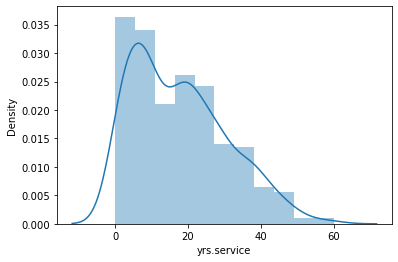

In [12]:
sns.distplot(df["yrs.service"])
df["yrs.service"].skew()

<AxesSubplot:>

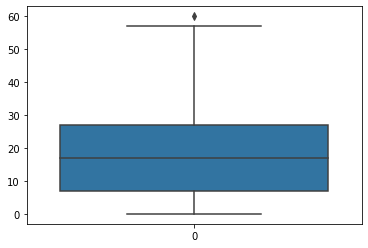

In [13]:
sns.boxplot(data=df["yrs.service"])

0.29591525646461886

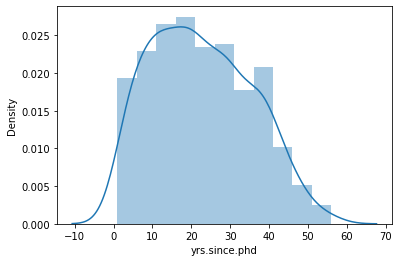

In [14]:
sns.distplot(df["yrs.since.phd"])
df["yrs.since.phd"].skew()

<AxesSubplot:>

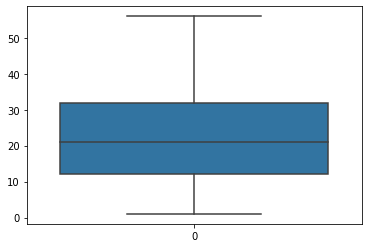

In [15]:
sns.boxplot(data=df["yrs.since.phd"])

Male      354
Female     39
Name: sex, dtype: int64

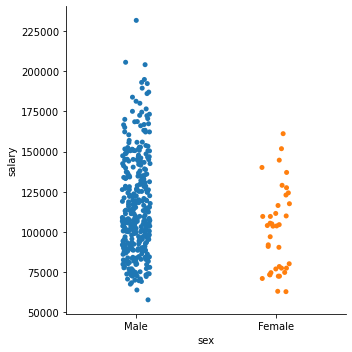

In [16]:
sns.catplot(x="sex", y="salary", data=data)
data.sex.value_counts()

B    212
A    181
Name: discipline, dtype: int64

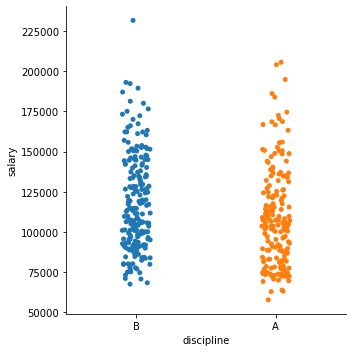

In [17]:
sns.catplot(x="discipline", y="salary", data=data)
data.discipline.value_counts()

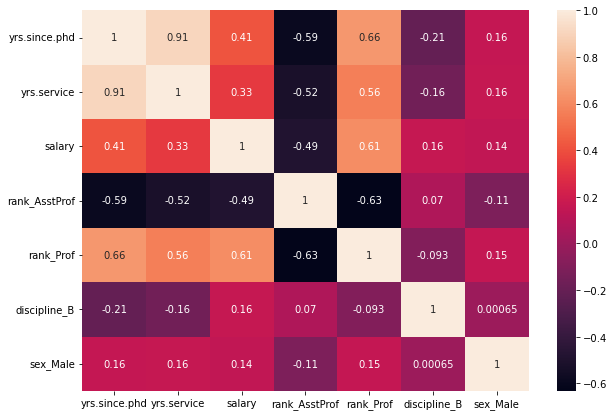

In [18]:
#Visualizing correlation among the variables
corr= df.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot= True)
plt.show()

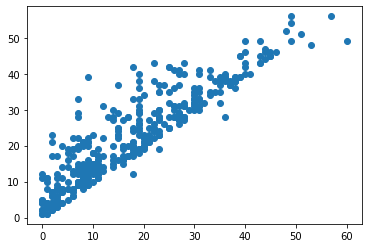

In [19]:
# Column yrs.service and yrs.since.phd seems to be correlated from the heat map. So, checking their plot against each other.
plt.scatter(df['yrs.service'],df['yrs.since.phd'])
plt.show()

#They seem to be linearly related with some noise.

In [20]:
df.corr()["salary"]

yrs.since.phd    0.414042
yrs.service      0.329624
salary           1.000000
rank_AsstProf   -0.487711
rank_Prof        0.612900
discipline_B     0.164018
sex_Male         0.141521
Name: salary, dtype: float64

In [21]:
X= df.drop(columns=["salary"])
y= df["salary"]

In [22]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_scaled= scaler.fit_transform(X)

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["vif"]=[variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"]= X.columns
print(vif)

        vif       Features
0  7.370746  yrs.since.phd
1  5.864981    yrs.service
2  1.837810  rank_AsstProf
3  2.121358      rank_Prof
4  1.059854   discipline_B
5  1.032732       sex_Male


In [24]:
#Dropping the yrs.service column.

df.drop(columns=["yrs.service"], inplace=True)

In [25]:
#Checking vif again.

X= df.drop(columns=["salary"])
y= df["salary"]

X_scaled= scaler.fit_transform(X)

vif = pd.DataFrame()
vif["vif"]=[variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"]= X.columns
print(vif)

        vif       Features
0  2.021844  yrs.since.phd
1  1.837484  rank_AsstProf
2  2.102506      rank_Prof
3  1.052094   discipline_B
4  1.030521       sex_Male


In [26]:
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=356)

ada = AdaBoostRegressor(n_estimators=100,learning_rate=0.3)
ada.fit(x_train, y_train)

y_pred_train = ada.predict(x_train)
accuracy_train = metrics.r2_score(y_train,y_pred_train)
print("Training Score:",round(accuracy_train*100,2))

y_pred= ada.predict(x_test)
accuracy_test = metrics.r2_score(y_test,y_pred)
print("Testing Score:",round(accuracy_test*100,2))

Training Score: 47.2
Testing Score: 45.64


In [27]:
#Hyperparameter tuning using GridSearchCV

from sklearn.model_selection import GridSearchCV

params= {"n_estimators": np.arange(50,200,25), "learning_rate": np.arange(0.01,0.50,0.01)}
grd= GridSearchCV(ada, param_grid=params,cv=5)

grd.fit(x_train,y_train)
print(grd.best_params_)

{'learning_rate': 0.060000000000000005, 'n_estimators': 50}


In [28]:
adaboost=grd.best_estimator_
adaboost.fit(x_train, y_train)

y_pred_train = adaboost.predict(x_train)
accuracy_train = metrics.r2_score(y_train,y_pred_train)
print("Training Score: ",round(accuracy_train*100,2))

y_pred= adaboost.predict(x_test)
accuracy_test = metrics.r2_score(y_test,y_pred)
print("Testing Score: ",round(accuracy_test*100,2)) 

Training Score:  50.33
Testing Score:  44.38


In [29]:
from sklearn.model_selection import cross_val_score, KFold

for i in range(5,10):
    cv_score= cross_val_score(adaboost,X_scaled,y,cv=i).mean()
    print("the cv score for",i,"fold:", cv_score*100)

the cv score for 5 fold: 37.31456880019061
the cv score for 6 fold: 42.857215077082614
the cv score for 7 fold: 42.058643484163454
the cv score for 8 fold: 42.185577889113745
the cv score for 9 fold: 36.02901998136472
